In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd 
from pythonds3.graphs import Graph, Vertex
from pythonds3.basic import Queue, Stack
from pythonds3.trees import PriorityQueue
from binarytree import build
import string
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import sys 

## Discussion Questions

In [59]:
""" 
1. Draw the graph corresponding to the following adjacency matrix.
"""

def G_from_adjacency_matrix(matrix, node_names):
    #if there is directionality, then we assume the rows are source nodes,
    #and cols are target nodes 
    assert len(matrix) == len(node_names)
    G = nx.MultiDiGraph()

    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            if matrix[row][col] is not None:
                G.add_edge(node_names[row], node_names[col], weight=matrix[row][col])
    return G

def visualise_nx_graph(graph, directed=True, multi_edge=True, graph_name=None,
show_edge_weights=True):
    assert graph_name is not None and '.html' in graph_name
    net = Network(notebook=True, directed=directed)
    if multi_edge:
        net.set_edge_smooth('dynamic')
    net.from_nx(graph, show_edge_weights=show_edge_weights)
    net.show(graph_name)

adjacencyMatrix = [
    [None, 7, 5, None, None, 1],
    [2, None, None, 7, 3, None],
    [None, 2, None, None, None, 8],
    [1, None, None, None, 2, 4],
    [6, None, None, 5, None, None],
    [None, 1, None, None, 8, None]
]

#need to set net to directed and set_edge_smooth to dynamic to enable multiple edges between nodes

net_d1 = Network(notebook=True, directed=True)
G = G_from_adjacency_matrix(adjacencyMatrix, string.ascii_uppercase[:6])

visualise_nx_graph(G, graph_name='disc_q1.html')

In [3]:
"""
2. Draw the graph corresponding to the following list of edges.
"""

G = nx.MultiDiGraph()
edges = [(1, 2, 10),
        (1, 3, 15),
        (1, 6, 5),
        (2, 3, 7),
        (3, 4, 7),
        (3, 6, 10),
        (4, 5, 7),
        (6, 4, 5),
        (5, 6, 13)]

for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

visualise_nx_graph(G, graph_name='disc_q2.html', show_edge_weights=False,
directed=True)


In [4]:
"""
3. Ignoring the weights, perform a breadth first search on the graph from the previous question

    - implementing bfs from scratch using networkx graph object as an alternative way of answering the question
"""

def bfs_nx(g, start_node=None):
    assert start_node in list(g)
    #set_node_attributes: if nodes not specified, then applies to all nodes
    nx.set_node_attributes(g, 0, 'explore_status')
    nx.set_node_attributes(g, 0, 'distance')
    nx.set_node_attributes(g, None, 'predecessor')
    explore_queue = Queue()
    explore_queue.enqueue(start_node)
    while not explore_queue.is_empty():
        current_node = explore_queue.dequeue()
        #only keep neighbours that are not dead ends 
        neighbours = [neigh for neigh in list(g[current_node]) if g.nodes[neigh]['explore_status'] != 2]
        for neigh in neighbours:
            #we set exploration status to 1 - indicating that we've visited this node before, and predecessor 
            if g.nodes[neigh]['explore_status'] == 0:
                nx.set_node_attributes(g, {neigh: {'explore_status': 1, 'predecessor': current_node,
                                                    'distance': g.nodes[current_node]['distance'] + 1}})
                explore_queue.enqueue(neigh)
        
        nx.set_node_attributes(g, {current_node: {'explore_status': 2}})
    

def bfs_predecessors_nx(g, start_node):
    bfs_nx(g, start_node=start_node)
    predecessors = []
    for node in list(g):
        if node != start_node:
            predecessors.append((node, g.nodes[node]['predecessor']))
    
    return predecessors

In [5]:
#test bfs implementation
n_trials = 100
for _ in tqdm(range(n_trials)):
    n_nodes = random.randint(10, 50)
    p = random.uniform(0.5, 0.9)
    random_graph = nx.gnp_random_graph(n_nodes, p=p)
    assert sorted(list(nx.bfs_predecessors(random_graph, 1))) == sorted(bfs_predecessors_nx(random_graph, 1))

100%|██████████| 100/100 [00:00<00:00, 379.32it/s]


4. What is the Big-O running time of the buildGraph function? 

```python
def buildGraph(wordFile):
    d = {}
    g = Graph()
    wfile = open(wordFile,'r')
    # create buckets of words that differ by one letter
    for line in wfile:
        word = line[:-1]
        for i in range(len(word)):
            bucket = word[:i] + '_' + word[i+1:]
            if bucket in d:
                d[bucket].append(word)
            else:
                d[bucket] = [word]
    """
    in this step, O(k*n) where k = 4 in this instance b/c length of words is 4. 
    """

    # add vertices and edges for words in the same bucket
    for bucket in d.keys():
        for word1 in d[bucket]:
            for word2 in d[bucket]:
                if word1 != word2:
                    g.addEdge(word1,word2)

    """
    The maximum number of words in a bucket is 26, and theoretical upper bound of the number of buckets is 
    26^(k-1). So the theoretical maximum number of edges added is 26^k (from 26 * 26^(k-1))
    But, of course majority of the letter combinations will not be words... and this considers ALL possible k letter word combinations 
    which is overkill.

    If we consider the input size (5110 words in this case), 
    if we take n/26 = ~197, we get the minimum possible number of buckets.
    This assumes the case where the word list perfectly segments into buckets of 26 words (WORSE case, but pretty much impossible b/c again, 
    most combinations won't be words). 
    in this case, we will need to create 197 * (26 * 25) = 133,172 edges (theoretical maximum of edges needed in this scenario - in the actual
    buildGraph output there were only ~53,000 edges)

    so, combining the two processes:
    O(k*n) + O(n/26 * 26 * 25) -> O(k*n + (n * 25)) -> O(n(k + 1))

    ^ this is just my thinking of the process... because I suppose this is a particular case where we can identify an upper bound to the number of 
    edges quite easily, and so was trying to think of it in a different way, where we can quantify the coefficients.
    But the answer to the question is really just O(n^2) b/c the second 
    process involves two nested for loops that, which essentially always comes to n * (n-1) = n^2 - n operations, it's just that the 
    coefficient would differ based on the average number of words in each bucket (e.g. for the sample problem the coefficient would be
    0.002. AND in theory as n increases the coefficient no longer matters, but you know number of words is a pretty finite problem so)
    """    

    return g

```


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


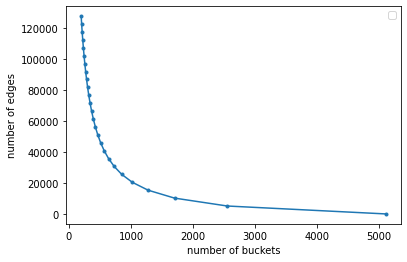

In [6]:
"""
Question 4. additional proof just to make sure my assumptions are correct in my own derivation... 
if the number of buckets increase, ie. the average number of words within each number decreases, the 
theoretical total possible number of edges added will also decrease.
"""

x = 5110
X = []
Y = []
for n_words in range(26, 0, -1):
    n_buckets = x/n_words 
    X.append(n_buckets)
    Y.append(n_buckets * (n_words * (n_words-1)))



plt.plot(X, Y, marker='.')

plt.xlabel('number of buckets')
plt.ylabel('number of edges')
plt.legend()


100%|██████████| 50/50 [00:00<00:00, 90433.46it/s]


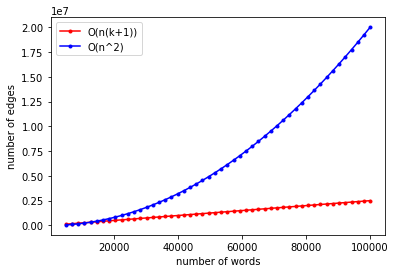

In [7]:
"""
Question 4. just wanted to have a look and compare the big-O that I derived and a straightforward n^2
- we naively assume that the coefficient is 0.002 for O(n^2) from the previous example
- we're just assuming the minimum number of buckets is obtained for each x, to maximise the number of edges
that are obtained
"""

X = np.linspace(5000, 100_000)
Y1 = []
Y2 = []
n_words_per_bucket = 26
for x in tqdm(X):
    n_buckets = x/n_words_per_bucket
    Y1.append(n_buckets * (n_words_per_bucket * (n_words_per_bucket-1)))
    Y2.append(0.002 * x**2)


plt.plot(X, Y1, marker='.', color='red', label='O(n(k+1))')
plt.plot(X, Y2, marker='.', color='blue', label='O(n^2)')


plt.xlabel('number of words')
plt.ylabel('number of edges')
plt.legend()



5.Derive the Big-O running time for the topological sort algorithm.


***
1. Call dfs(g) for some graph g. The main reason we want to call depth first search is to compute the finish times for each of the vertices.
***
    Time complexity of dfs is O(V + E)
***


2. Store the vertices in a list in decreasing order of finish time.
***
    We can store vertices during dfs; the main insight is that dfs always arrives at the final 
    node in the dfs tree first, and completes it, then goes back to complete the previous nodes. 
    Again, b/c dfs is a recursive function, it essentially is serving as a stack that pushes out 
    nodes as they "finish". So, during DFS, we simply need to append the finished nodes into self.finish_order
    to obtain an ordered list of nodes with increasing finishing times.
    We then return the reversed list (or we can list.insert(0, node) during dfs if we wish) as the result for topological sort.
    So this step does not increase the time complexity of that of dfs!
***

3. Return the ordered list as the result of the topological sort.
***
    Here we just need to reverse the list, which is an O(V) operation
***

Combining the big-O if the two operations:
***
    O(V+E) + O(V) -> O(V+E)
***


In [8]:
class Base_NX:
    def __init__(self, g):
        self._g = g 

    def set_node_attribute(self, g, vertex=None, key=None, val=None):
        if vertex is None:
            #if no vertex is specified then we just set it for all nodes
            nx.set_node_attributes(g, val, key)
        else:
            assert vertex in list(g)
            nx.set_node_attributes(g, {vertex: {key: val}})

    def get_node_attribute(self, g, vertex, key):
        assert vertex in list(g)
        return g.nodes[vertex][key]

    def get_out_edges(self, vertex, data=True):
        if not nx.is_directed(self._g):
            return list(self._g.edges(vertex, data=data))
        else:
            return list(self._g.out_edges(vertex, data=data))

    def check_graph(self):
        raise NotImplementedError()

#add an animate function here?
        

In [9]:
#implentation of Q5 topological sort

class TopologicalSort_NX(Base_NX):
    __explore_status__ = 'explore_status'
    __predecessor__ = 'predecessor'
    __discovery_time__ = 'discovery_time'
    __finish_time__ = 'finish_time'
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._topological_finish_order = Stack()
        self.time = 0

    def check_graph(self):
        if self._g is None:
            raise Exception('no networkx graph object stored')
        if not nx.is_directed_acyclic_graph(self._g):
            raise Exception('graph is not a DAG.')

    def _topological_dfs(self):
        self.check_graph()

        #reset parameters
        self.time = 0
        self._topological_finish_order = []
        self.set_node_attribute(self._g, key=TopologicalSort_NX.__explore_status__, val=0)
        self.set_node_attribute(self._g, key=TopologicalSort_NX.__predecessor__, val=None)
        self.set_node_attribute(self._g, key=TopologicalSort_NX.__discovery_time__, val=-1)
        self.set_node_attribute(self._g, key=TopologicalSort_NX.__finish_time__, val=-1)

        for vertex in list(self._g):
            if self._g.nodes[vertex][TopologicalSort_NX.__explore_status__] == 0:
                self._topological_dfsVisit(self._g, vertex, self._topological_finish_order)


    def _topological_dfsVisit(self, g, start_vertex, finish_order):
        self.time += 1
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=1)
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__discovery_time__, val=self.time)

        #not going through NEIGHBOURS!!! going through CHILDREN
        for _, child in list(g.out_edges(start_vertex)):
            if self.get_node_attribute(g, child, TopologicalSort_NX.__explore_status__) == 0:
                self.set_node_attribute(g, vertex=child, key=TopologicalSort_NX.__explore_status__, val=1)
                self.set_node_attribute(g, vertex=child, key=TopologicalSort_NX.__predecessor__, val=start_vertex)
                self._topological_dfsVisit(g, child, finish_order)
        
        self.time += 1
        #finish node exploration
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__finish_time__, val=self.time)
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=2)
        #here we append the finished vertex to self.order for topologicalSort
        #check that the finishing time for this node is larger than the latest entry in finish_order
        if len(finish_order):
            last = self.get_node_attribute(g, vertex=finish_order[-1], key=TopologicalSort_NX.__finish_time__)
            curr = self.get_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__finish_time__)
            assert last < curr
        finish_order.append(start_vertex)

    
    def topologicalSort(self):
        self._topological_dfs()
        return self._topological_finish_order[::-1]
        



In [10]:
class GraphGenerator_Base:
    def __init__(self, min_n=10, max_n=100, min_p=0.25, max_p=0.75, 
                directed=True, weighted=True, min_weight=1, max_weight=10):
        self.min_n = min_n
        self.max_n = max_n 
        self.min_p = min_p
        self.max_p = max_p 
        self.is_directed = directed 
        self.is_weighted = weighted
        self.min_weight = min_weight 
        self.max_weight = max_weight 

        assert max_n > min_n and min_n > 0
        assert max_p > min_p and max_p <= 1
        assert max_weight > min_weight 

    def generate_n(self):
        return random.randint(self.min_n, self.max_n)

    def generate_p(self):
        return random.uniform(self.min_p, self.max_p)

    def generate_g(self):
        return nx.gnp_random_graph(self.generate_n(), self.generate_p(), directed=self.is_directed)

    def generate_weight(self):
        return {'weight': random.randint(self.min_weight, self.max_weight)}

    def generate_graph(self):
        raise NotImplementedError()


In [11]:
class DAG_Generator(GraphGenerator_Base):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def generate_graph(self):
        g = self.generate_g()

        if self.is_weighted:
            DAG = nx.MultiDiGraph([(u, v, self.generate_weight()) for (u,v) in g.edges() if u < v])
        else:
            DAG = nx.MultiDiGraph([(u, v) for (u,v) in g.edges() if u < v])

        assert nx.is_directed_acyclic_graph(DAG)
        return DAG

In [12]:
#test Topological sort implementation 

def topological_sort_check(graph, res, mode='vertex'):
    """
    Topological sort definition:
    an ordering of the nodes such that for every edge (u,v) in G,
    u appears earlier than v in the ordering

    - edge and vertex modes look at the same thing, just examining it from a different perspective
    """

    if mode == 'vertex':
        """
        vertex mode:
        we iterate through the vertices from the sort.
        At each vertex we look at the outgoing edges. If the target of any outgoing edges precedes the 
        vertex in the ordering, then the sort result is invalid!

        time complexity: O(V^2 * E)
        """
        for i,node in enumerate(res):
            preceding = res[:i]
            out_edges = graph.out_edges(node)
            for _, target in out_edges:
                if target in preceding:
                    return False 
    elif mode == 'edge':
        """
        edge mode:
        we look at all the edges in G. for each edge, we get the index of its vertex
        within the ordering. If the origin vertex isn't earlier than the target vertex,
        then the ordering is invalid!
        - here it's important that the graph is a DAG, because or else there will exist edges 
        that point from a later ordering back to an earlier vertex
        - BASICALLY the definitin of topological ordering (look above)

        time complexity: O(E*V)
        """
        edges = list(graph.edges())
        for source, target in edges:
            source_idx = res.index(source)
            target_idx = res.index(target)
            if source_idx > target_idx:
                return False

    elif mode == 'finish_time':
        """
        just checks that the finish_time is in decreasing order as a way of validating the results
        """
        prev = None
        for node in res:
            curr = graph.nodes[node]['finish_time']
            if prev is not None:
                if prev < curr:
                    return False 
            prev = curr 

    return True

                    

n_trials = 100
generator = DAG_Generator()
for _ in tqdm(range(n_trials)):
    dag = generator.generate_graph()
    ts = TopologicalSort_NX(dag)
    res = ts.topologicalSort()
    assert topological_sort_check(ts._g, res, mode='edge')



100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


6.Derive the Big-O running time for the strongly connected components algorithm.

1. Call dfs for the graph  to compute the finish times for each vertex.

***
    Time complexity of dfs is O(V+E)
***

2. Compute G<sup>T</sup>
***
    Time complexity of the transpose computation is O(E) (b/c we're just flipping every edge)
***

3. Call dfs for the graph  but in the main loop of DFS explore each vertex in decreasing order of finish time.
***
    Time complexity of dfs is O(V+E) again. As for exploring each vertex in decreasing order of finish time in the main loop,
    we can store the vertices from the first dfs as we do in topologicalsort, so obtaining this list would just be a matter iterating in reverse over of the saved list, which wouldn't add to the time complexity.
***

4. Each tree in the forest computed in step 3 is a strongly connected component. Output the vertex ids for each vertex in each tree in the forest to identify the component.
***
    Outputting the vertex ids for each vertex in each tree can be incorporated into the second dfs, where in the main loop we can keep track
    of the current tree, appending nodes within the nested dfs calls. When a new node is explored in the main loop, we start a new tree to 
    keep track of. So this operation does not add additional time complexity.
***

Combining everything:
***
    O(V+E) + O(E) + O(V+E) -> O(V+E)
***


In [13]:
#Implementation of the SCC algorithm

class SCC_NX(TopologicalSort_NX):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._gT = None
        self._scc_trees = []

    def _transpose_graph(self):
        if self._g is None:
            raise Exception('no graph object stored')
        edges = list(self._g.edges())
        #reverse direction of edges
        reversed = [(target, source) for (source, target) in edges]
        self._gT = nx.MultiDiGraph()
        self._gT.add_edges_from(reversed)

    def check_graph(self):
        if self._g is None:
            raise Exception('no networkx graph object stored')
        if not nx.is_directed(self._g):
            raise Exception('graph is not directed!')

    def _scc_dfs(self):
        if self._gT is None:
            raise Exception('no gT stored')
        #reset parameters
        self.time = 0
        self._scc_finish_order = []
        self._scc_trees = []
        self.set_node_attribute(self._gT, key=TopologicalSort_NX.__explore_status__, val=0)
        self.set_node_attribute(self._gT, key=TopologicalSort_NX.__predecessor__, val=None)
        self.set_node_attribute(self._gT, key=TopologicalSort_NX.__discovery_time__, val=-1)
        self.set_node_attribute(self._gT, key=TopologicalSort_NX.__finish_time__, val=-1)

        #the key difference here is just that we're iterating through the list of nodes in 
        #decreasing finishing time from the first dfs
        #here also we save the trees created during dfs!
        curr_tree = []
        for vertex in self._topological_finish_order[::-1]:
            if self.get_node_attribute(self._gT, vertex, TopologicalSort_NX.__explore_status__) == 0:
                if len(curr_tree):
                    self._scc_trees.append(curr_tree)
                    
                curr_tree = []
                self._scc_dfsVisit(self._gT, vertex, curr_tree)

        if len(curr_tree):
            self._scc_trees.append(curr_tree)

    def _scc_dfsVisit(self, g, start_vertex, curr_tree):
        self.time += 1
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=1)
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__discovery_time__, val=self.time)

        #adding current node to curr_tree
        curr_tree.append(start_vertex)

        #Here we are only extracting the out edges!
        for _, child in list(g.out_edges(start_vertex)):
            if self.get_node_attribute(g, child, TopologicalSort_NX.__explore_status__) == 0:
                self.set_node_attribute(g, vertex=child, key=TopologicalSort_NX.__explore_status__, val=1)
                self.set_node_attribute(g, vertex=child, key=TopologicalSort_NX.__predecessor__, val=start_vertex)
                self._scc_dfsVisit(g, child, curr_tree)

        self.time += 1
        #finish node exploration
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__finish_time__, val=self.time)
        self.set_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=2)
                

    def StronglyConnectedComponents(self):
        self.topologicalSort()
        self._transpose_graph()
        self._scc_dfs()
        return self._scc_trees


In [14]:
class RandomGraph_Generator(GraphGenerator_Base):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def generate_graph(self):
        base = self.generate_g()
        if self.is_directed:
            if self.is_weighted:
                g = nx.MultiDiGraph([(u,v, self.generate_weight()) for u,v in base.edges()])
            else:
                g = nx.MultiDiGraph([(u,v) for u,v in base.edges()])
        else:
            if self.is_weighted:
                g = nx.MultiGraph([(u, v, self.generate_weight()) for u,v in base.edges()])
            else:
                g = nx.MultiGraph([(u,v) for u,v in base.edges()])
        return g

In [61]:
def check_scc(res, g):
    #transform sets into list 
    ans = sorted([list(scc) for scc in list(nx.strongly_connected_components(g))])
    if ans == sorted([sorted(r) for r in res]):
        return True 
    else:
        return False


n_trials = 100
generator = RandomGraph_Generator(min_n=10, max_n=100, min_p=0.25, max_p=0.75, weighted=False,
                                directed=True)
for _ in tqdm(range(n_trials)):
    n = random.randint(10, 100)
    p = random.uniform(0.25, 0.75)
    g = generator.generate_graph()
    scc = SCC_NX(g)
    res = scc.StronglyConnectedComponents()
    assert check_scc(res, g)

    


100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


In [16]:
"""
7. Show each step in applying Dijkstra’s algorithm to the graph shown above.

- we will just implement Dijkstra's algorithm for nx graphs as an answer 
"""

class Dijkstra_NX(Base_NX):
    __dist__ = 'dist'
    __pred__ = 'predecessor'

    def __init__(self, *args, **kwargs):
        """
        Main feature of this algo is the priorityQueue, where we always explore the current available
        shortest path! This is an example of a greedy algorithm, because we assume that for example 
        a -> b -> c, that the shortest path from a -> b will lead us to the solution to the shortest 
        path for a -> c (solving subproblems to solve the global problem)
        
        """
        super().__init__(*args, **kwargs)
        self._queue = PriorityQueue()


    def enqueue(self, vert):
        dist = self.get_node_attribute(self._g, vertex=vert, key=Dijkstra_NX.__dist__)
        self._queue.insert((dist, vert))

    def dequeue(self):
        return self._queue.delete()

    def dijkstra(self, start_node):
        #check that the graph has a 'weight' attribute for edges 
        self.check_graph()
        #set starting parameters
        self.set_node_attribute(self._g, key=Dijkstra_NX.__dist__, val=sys.maxsize)
        self.set_node_attribute(self._g, vertex=start_node, key=Dijkstra_NX.__dist__, val=0)
        self.set_node_attribute(self._g, key=Dijkstra_NX.__pred__, val=None)
        self.enqueue(start_node)
        while not self._queue.is_empty():
            curr_dist, current = self.dequeue()
            edges = self.get_out_edges(current)
            for _, neigh, data in edges:
                #get new dist of current neighbour
                weight = data['weight']                
                if weight < 0:
                    raise Exception('Negative edge weight found.')
                new_dist = curr_dist + weight
                neigh_dist = self.get_node_attribute(self._g, vertex=neigh, key=Dijkstra_NX.__dist__)
                if new_dist < neigh_dist:
                    self.set_node_attribute(self._g, vertex=neigh, key=Dijkstra_NX.__pred__, val=current)
                    self.set_node_attribute(self._g, vertex=neigh, key=Dijkstra_NX.__dist__, val=new_dist)
                    if neigh in self._queue:
                        self._queue.change_priority(neigh, new_dist)
                    else:
                        self.enqueue(neigh)

    def shortest_path(self, target_node):
        """returns the shortest path from source node and the path length in a tuple"""
        n_nodes = self._g.number_of_nodes()
        i = 0
        path = []
        curr_node = target_node
        while curr_node is not None and i <= n_nodes:
            path.append(curr_node)
            curr_node = self.get_node_attribute(self._g, curr_node, key=Dijkstra_NX.__pred__)
            i += 1 
        
        if i > n_nodes:
            raise Exception('Path length is greater than number of nodes.')

    
        total_dist = self.get_node_attribute(self._g, target_node, key=Dijkstra_NX.__dist__)
        if total_dist == sys.maxsize:
            #there is no path towards target node
            return None

        return (path[::-1], total_dist)


    def check_graph(self):
        if self._g is None:
            raise Exception('No graph data stored!')
        edges = list(self._g.edges(data=True))
        if 'weight' not in edges[0][2]:
            raise Exception('Graph edges are not weighted!')


        



In [89]:
#test dijkstra implementation
def check_dijkstra(res, ans, target_node):
    """
    if range between min and max weight is too small, we can encounter multiple possible shortest paths,
    and so the answer generated might not be the same as nx's dijkstra implementation, so in the check
    we allow for that difference and as long as the shortest path length is the same we accept it
    """
    if res is None:
        assert target_node not in ans[0]
        print('No path to node.')
        return True
    else:
        path_correct = True 
        length_correct = True 

        if res[0] != ans[1][target_node]:
            print(res[0], ans[1][target_node])
            path_correct = False 
        if res[1] != ans[0][target_node]:
            print(res[1], ans[0][target_node])
            length_correct = False

        if not path_correct and length_correct:
            print('Different shortest path, but same length.')
            return True
        elif not path_correct and not length_correct:
            print('Different path and different length.')
            return False
        elif path_correct and length_correct:
            return True

n_trials = 100
generator = RandomGraph_Generator(min_n=10, max_n=100, min_p=0.25,
                                max_p=0.75, weighted=True, min_weight=1, max_weight=1000, 
                                directed=True)

for _ in tqdm(range(n_trials)):
    g = generator.generate_graph()
    dijkstra = Dijkstra_NX(g)
    start_node = random.choice(list(g))
    ans = nx.single_source_dijkstra(g, start_node)
    dijkstra.dijkstra(start_node=start_node)
    for target_node in list(g):
        res = dijkstra.shortest_path(target_node)
        assert check_dijkstra(res, ans, target_node)

        


100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


In [83]:
visualise_nx_graph(g, graph_name='dijkstra.html', show_edge_weights=True)

In [ ]:
""" 
8. Using Prim’s algorithm, find the minimum weight spanning tree for the graph shown above.
- we will implement it for NX graphs as an answer.
"""

class Prims_NX(Base_NX):
    def __init__(*args, **kwargs):
        super().__init__(*args, **kwargs)

    def check_graph(self):
        #weighted, undirected graph
        if self._g is None:
            raise Exception('No graph data stored!')
        edges = list(self._g.edges(data=True))
        if 'weight' not in edges[0][2]:
            raise Exception('Graph edges are not weighted!')
        
        if nx.is_directed(self._g):
            raise Exception('Graph must be undirected.') 

        